In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

In [3]:
tf.__version__

'2.7.0'

# **Load Dataset from Kaggle**

In [4]:
!pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hoanghaimy","key":"428e41cea6dd3c88e59c119ea5664930"}'}

In [5]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d deadskull7/fer2013

 83% 80.0M/96.6M [00:02<00:00, 29.8MB/s]
100% 96.6M/96.6M [00:02<00:00, 47.7MB/s]


In [7]:
!unzip fer2013.zip

Archive:  fer2013.zip
  inflating: fer2013.csv             


In [8]:
df = pd.read_csv('fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [9]:
df.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [10]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [11]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

# **Preprocessing Dataset**

In [12]:
num_classes = 7
label_to_text = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [13]:
train_set = df[(df.Usage == 'Training')] 
val_set = df[(df.Usage == 'PublicTest')]
test_set = df[(df.Usage == 'PrivateTest')] 

X_train = np.array(list(map(str.split, train_set.pixels)), np.float32) 
X_val = np.array(list(map(str.split, val_set.pixels)), np.float32) 
X_test = np.array(list(map(str.split, test_set.pixels)), np.float32)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [14]:
num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]

In [15]:
num_train
#num_val
#num_test

28709

In [16]:
y_train = train_set.emotion 
y_train = np_utils.to_categorical(y_train, num_classes) # convert to one-hot vector
y_val = val_set.emotion 
y_val = np_utils.to_categorical(y_val, num_classes) 
y_test = test_set.emotion 
y_test = np_utils.to_categorical(y_test, num_classes) 

In [17]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator( 
    rescale=1./255)

datagen.fit(X_train)

batch_size = 64

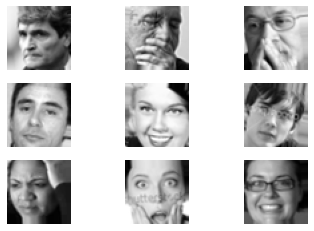

In [18]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9): 
        pyplot.axis('off') 
        pyplot.subplot(330 + 1 + i) 
        pyplot.imshow(X_batch[i].reshape(48, 48), cmap=pyplot.get_cmap('gray'))
    pyplot.axis('off') 
    pyplot.show() 
    break 

In [19]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
val_flow = testgen.flow(X_val, y_val, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size) 

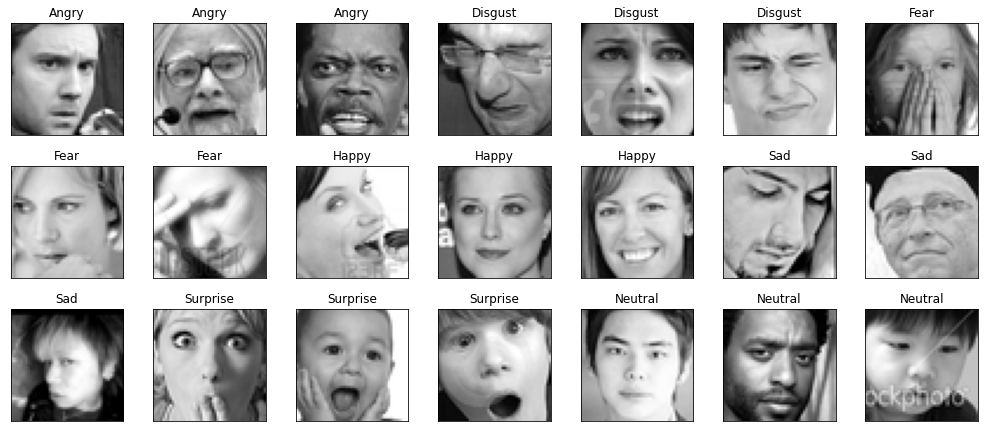

In [20]:
# Visulize sample dataset
fig = pyplot.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(3):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        pyplot.tight_layout()

In [21]:
X_train.shape

(28709, 48, 48, 1)

# **Buiding Model**

In [22]:
basemodel = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape = (48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        tf.keras.layers.BatchNormalization(),
                                        #
                                        tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape = (48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        tf.keras.layers.BatchNormalization(),
                                        #
                                        tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape = (48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        tf.keras.layers.BatchNormalization(),
                                        #
                                        tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape = (48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(1000,activation = 'relu'),
                                        tf.keras.layers.Dense(7,activation = 'softmax')                          
                                        ])

In [23]:
basemodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                        

In [24]:
basemodel.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=.0001),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

In [25]:
file_name = 'best_model.h5'
checkpoint_path = os.path.join('/content/gdrive/MyDrive/Facial_Expression_TF/checkpoint/', file_name)

call_back = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                               monitor = 'val_accuracy',
                                               verbose= 1,
                                               save_freq = 'epoch',
                                               save_best_only = True,
                                               save_weights_only = False,
                                               mode = 'max'
                                               )

In [26]:
checkpoint_path

'/content/gdrive/MyDrive/Facial_Expression_TF/checkpoint/best_model.h5'

# **Training Model**

In [27]:
history = basemodel.fit(train_flow, epochs = 50, validation_data=val_flow, callbacks = call_back)

Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 1.6425 - accuracy: 0.3502
Epoch 00001: val_accuracy improved from -inf to 0.28643, saving model to /content/gdrive/MyDrive/Facial_Expression_TF/checkpoint/best_model.h5
449/449 [==============================] - 36s 51ms/step - loss: 1.6425 - accuracy: 0.3502 - val_loss: 1.7411 - val_accuracy: 0.2864
Epoch 2/50
448/449 [============================>.] - ETA: 0s - loss: 1.4785 - accuracy: 0.4326
Epoch 00002: val_accuracy improved from 0.28643 to 0.45890, saving model to /content/gdrive/MyDrive/Facial_Expression_TF/checkpoint/best_model.h5
449/449 [==============================] - 21s 48ms/step - loss: 1.4786 - accuracy: 0.4324 - val_loss: 1.3985 - val_accuracy: 0.4589
Epoch 3/50
448/449 [============================>.] - ETA: 0s - loss: 1.3937 - accuracy: 0.4696
Epoch 00003: val_accuracy improved from 0.45890 to 0.48119, saving model to /content/gdrive/MyDrive/Facial_Expression_TF/checkpoint/best_model.h5
449/449 [==

In [28]:
test_loss, test_acc = basemodel.evaluate( test_flow, verbose=2)

print('\nTest accuracy:', test_acc)

57/57 - 0s - loss: 1.0769 - accuracy: 0.6038 - 490ms/epoch - 9ms/step

Test accuracy: 0.6037893295288086


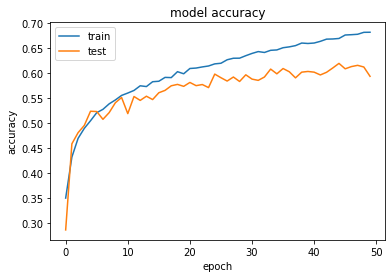

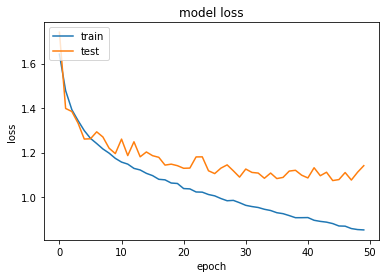

In [30]:
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()
# summarize history for loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

predicted label is Happy


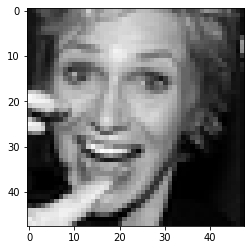

KeyboardInterrupt: ignored

In [32]:
final_model = tf.keras.models.load_model(checkpoint_path)

from IPython.display import clear_output
import time

for k in range(40):
  #print(f'actual label is {label_to_text[y_test[k]]}')
  predicted_class = final_model.predict(tf.expand_dims(X_test[k], 0)).argmax()
  print(f'predicted label is {label_to_text[predicted_class]}')
  pyplot.imshow(X_test[k].reshape(48,48), cmap = 'gray')
  pyplot.show()
  time.sleep(3)
  clear_output(wait=True)